<a href="https://colab.research.google.com/github/AtaErnam/CS412_Project/blob/main/merged_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.1 MB/s eta 0:00:00


In [2]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from collections import Counter
import xgboost as xgb
from xgboost import plot_importance
from catboost import CatBoostRegressor
from textblob import TextBlob

import tensorflow as tf

import gensim.downloader
from gensim.models import Word2Vec
import nltk

In [4]:
data_path = "/content/drive/MyDrive/cs412/dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 128/128 [00:27<00:00,  4.60it/s]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"])

[{'role': 'user',
  'text': 'Load a CSV file into a Pandas in Python. The file is named '
          "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
          "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
          "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
          "'Health Metrics'. \n"},
 {'role': 'assistant',
  'text': 'You can load a CSV file into a Pandas DataFrame in Python using the '
          "pandas.read_csv() function. Here's how you can do it for your "
          'specific CSV file:pythonCopy codeimport pandas as pd\n'
          '\n'
          '# Specify the file path\n'
          "file_path = 'cs412_hw1_dataset.csv'\n"
          '\n'
          '# Load the CSV file into a Pandas DataFrame\n'
          'df = pd.read_csv(file_path)\n'
          '\n'
          '# Display the first few rows of the DataFrame to verify the data '
          'has been loaded\n'
          'print(df.head())\n'
          "This code assume

In [6]:
import tqdm
from glob import glob
import os
from bs4 import BeautifulSoup
import pandas as pd
import re

data_path = "/content/drive/MyDrive/cs412/dataset/*.html"
code2convos = dict()
total_code_response_list = []
pbar = tqdm.tqdm(sorted(list(glob(data_path))))

for path in pbar:
    code_block_count = 0
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
        html_page = fh.read()
        soup = BeautifulSoup(html_page, "html.parser")

        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})
        convo_text = []
        last_user_text = None  # Keep track of the last user message

        for i, convo in enumerate(conversations):
            user_div = convo.find("div", attrs={"data-message-author-role": "user"})
            assistant_div = convo.find("div", attrs={"data-message-author-role": "assistant"})

            # When a user message is found, save it to last_user_text
            if user_div:
                last_user_text = user_div.text.strip()

            # Check if the assistant message contains a code block
            if assistant_div and assistant_div.find("code"):
                code_block_count += 1

            # Pair every assistant message with the last user message
            if assistant_div and last_user_text is not None:
                convo_text.append({
                    "role": "user",
                    "text": last_user_text,
                    "response": assistant_div.text.strip()
                })
                last_user_text = None  # Reset last_user_text after pairing

        total_code_response_list.append((file_code, code_block_count))
        code2convos[file_code] = convo_text

total_code_response_df = pd.DataFrame(total_code_response_list, columns=['code', 'code_responses'])


100%|██████████| 128/128 [00:30<00:00,  4.20it/s]


In [7]:
total_code_response_df.head()

,code,code_responses
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14
1,0225686d-b825-4cac-8691-3a3a5343df2b,17
2,041f950b-c013-409a-a642-cffff60b9d4b,7
3,04f91058-d0f8-4324-83b2-19c671f433dc,19
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,82


In [8]:
import pandas as pd

# Flatten the code2convos structure to include only the assistant's responses
all_responses = []
for file_code, conversations in code2convos.items():
    for convo in conversations:
        # Create a dictionary for each assistant response
        convo_dict = {
            'code': file_code,  # Identifier of the file (or student)
            'response': convo['response']  # The assistant's response
        }
        all_responses.append(convo_dict)

# Create a DataFrame from this list
responses_df = pd.DataFrame(all_responses)

# Display the first few rows of the DataFrame to verify
print(responses_df.head())


                                   code  \
0  0031c86e-81f4-4eef-9e0e-28037abf9883   
1  0031c86e-81f4-4eef-9e0e-28037abf9883   
2  0031c86e-81f4-4eef-9e0e-28037abf9883   
3  0031c86e-81f4-4eef-9e0e-28037abf9883   
4  0031c86e-81f4-4eef-9e0e-28037abf9883   

                                            response  
0  You can load a CSV file into a Pandas DataFram...  
1  You can use Pandas to understand a dataset by ...  
2  To preprocess the dataset as per your requirem...  
3  Certainly, here's the code to shuffle the Data...  
4  To calculate and visualize the correlations of...  


In [9]:
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'response': 'You can load a CSV file into a Pandas DataFrame in Python using '
             "the pandas.read_csv() function. Here's how you can do it for "
             'your specific CSV file:pythonCopy codeimport pandas as pd\n'
             '\n'
             '# Specify the file path\n'
             "file_path = 'cs412_hw1_dataset.csv'\n"
             '\n'
             '# Load the CSV file into a Pandas DataFrame\n'
             'df = pd.read_csv(file_path)\n'
             '\n'
             '# Display the first few rows of the DataFrame to verify the data '
             'has been loaded\n'
             'print(df.head())\n'
             "This code assumes that the CSV file 'cs412_hw1_dataset.csv' is "
             'in the same directory as your Python script or Jupyter Notebook. '
             'If the file is in a different directory, you can specify the '
             'full path to the file in the file_path variable.The '
             'pd.read_csv() function will automatically infer

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [10]:
prompts = []
characters_to_remove = ["\n","`",'\\']
code2prompts = defaultdict(list)
code2prompts_str = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
          for element in characters_to_remove: #Removal of such characters
            conv["text"] = conv["text"].replace(element,"")
          prompts.append(conv["text"])
          user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [11]:
questions = [ #Removed a question here wasn't leading to points also removed some characters!
#####################
    """Load training dataset
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset and Preprocessing
Understanding the Dataset:
Find the shape of the dataset (number of samples and number of attributes). (Hint: You can use the **shape** function)
Display variable names (both dependent and independent).
Display the summary of the dataset. (Hint: You can use the **info** function)
Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing:
Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**
Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X and y, split data

Shuffle the dataset.
Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations

Correlations of features with health
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

Feature Selection
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

Hypothetical Driver Features
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

""",
#####################
"""Tune Hyperparameters
Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values.
Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)*
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen
Re-train model with the hyperparameters you have chosen in part 5).
Plot the tree you have trained.
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set
Predict the labels of testing data using the tree you have trained in step 6.
Report the classification accuracy.
Plot & investigate the confusion matrix. Fill the following blanks.
The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split"""
#####################
]
for item in questions:
  for element in characters_to_remove: #Removal of such characters
    item = item.replace(element,"")


In [12]:
#Train A Word2Vec Model
nltk.download('punkt')

# Tokenize sentences and create a flat list of sentences
sentence_load = []
test_list = list(code2prompts.values())
test_list.append(questions)
for sentences in test_list:
    for sentence in sentences:
        # Tokenize each sentence
        tokenized_sentence = nltk.word_tokenize(sentence)
        sentence_load.append(tokenized_sentence)

# Training the Word2Vec model
vector_size = 600
window = 5
min_count = 2

hw_grading_word2vec_model = Word2Vec(
    sentences=sentence_load,
    vector_size=vector_size,
    window=window,
    min_count= min_count,
    workers=10
)
hw_grading_word2vec_model
#Train A Word2Vec Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
def vectorize_sentence(prompt): ## Each sentence of prompt being vectorized
  user_vector_list = list([])
  for sentence in prompt:
    tokens = sentence.split()
    word_vectors = [hw_grading_word2vec_model.wv[word] for word in tokens if word in hw_grading_word2vec_model.wv]
    if not word_vectors:
      user_vector_list.append(np.zeros(hw_grading_word2vec_model.vector_size))
      continue
    user_vector_list.append(np.mean(word_vectors, axis=0))
  return user_vector_list

code2prompts_word2vec = dict()
for code, user_prompts in code2prompts.items():
  if len(user_prompts) == 0:
      print(code+".html")
      continue
  prompts_word2Vec = pd.DataFrame(vectorize_sentence(user_prompts))
  code2prompts_word2vec[code] = prompts_word2Vec

questions_word2Vec = pd.DataFrame(vectorize_sentence(questions)) #Questions vectorized


139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [14]:
code2prompts_word2vec["7ac3f7a5-bdbb-470c-a1b3-03da5887a408"]

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.340675,0.012718,-0.145070,-0.000201,-0.062357,0.076168,0.192274,0.333620,0.147530,0.225756,...,-0.139233,0.047290,-0.020588,-0.209387,0.050270,0.162433,0.011035,-0.036981,-0.080234,-0.161604
1,0.628422,-0.214335,-0.125899,-0.000686,0.088931,0.096968,0.044259,0.328270,0.335844,0.333625,...,0.097306,0.034340,-0.146155,-0.384975,0.122658,0.263853,0.174953,-0.046687,-0.117983,-0.202019
2,0.379061,0.161767,-0.161451,-0.128641,0.122366,0.178498,0.468494,0.522349,0.182976,0.170720,...,-0.287638,0.026966,0.145335,-0.189677,0.123969,0.185701,-0.296567,-0.257929,0.005396,-0.074798
3,0.181647,-0.014920,0.041114,0.064713,-0.058747,0.068355,0.398974,0.381548,0.093276,-0.054658,...,-0.046691,-0.033162,0.105640,-0.022363,0.281143,0.235432,-0.240940,-0.418869,-0.003552,-0.275600
4,0.567685,-0.216982,-0.162724,0.055598,0.061068,0.176895,-0.013127,0.374058,0.301426,0.366080,...,0.039333,0.088536,-0.104611,-0.264088,0.174364,0.306814,0.151906,-0.068784,-0.083345,-0.141927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.487040,0.160028,-0.220445,-0.014563,0.209801,0.123123,0.060282,0.484014,0.082930,0.281809,...,0.079146,0.090251,-0.140683,-0.139778,-0.128224,0.340347,0.172062,0.048635,-0.163721,-0.224457
60,0.598405,-0.130073,-0.031041,0.113935,-0.155316,0.129495,0.163356,0.378171,0.031295,0.139154,...,0.496796,0.382571,-0.103604,-0.036720,0.237985,0.357564,-0.033474,0.345035,-0.048233,-0.287428
61,0.448316,-0.053834,-0.101246,-0.054565,0.152269,0.066031,0.350676,0.540852,0.056024,0.062558,...,0.141821,0.195432,-0.079341,-0.223070,0.265617,0.319491,-0.048043,0.058846,-0.163348,-0.323147
62,0.298516,0.203203,-0.212510,-0.036875,0.010438,-0.024188,0.104575,0.492815,0.166657,0.170652,...,0.070680,0.114712,-0.054833,-0.138493,0.119308,0.379552,0.062710,-0.024649,-0.222971,-0.251837


In [15]:
questions_word2Vec

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.434459,-0.081598,-0.086910,0.005674,0.061895,0.120076,0.099384,0.333053,0.136420,0.318335,...,-0.046863,0.144450,-0.057107,-0.204352,0.030537,0.318152,0.026771,-0.067176,-0.146321,-0.133705
1,0.440563,-0.137999,-0.114715,0.115417,0.096908,0.137220,0.165910,0.339294,0.217535,0.260915,...,-0.026557,0.120880,-0.055676,-0.187269,0.002728,0.329229,0.088975,-0.138418,-0.036585,-0.227883
2,0.401834,0.121262,-0.093868,-0.028635,0.131263,0.042808,0.231393,0.368078,0.093077,0.185382,...,-0.153367,0.069385,0.094823,-0.104186,0.043006,0.181360,-0.175356,-0.136938,-0.058814,-0.132740
3,0.249002,-0.097315,0.088818,0.035021,-0.124173,0.026579,0.400985,0.536009,0.012095,0.196187,...,-0.227482,0.166944,0.064099,-0.192592,-0.051273,0.005285,-0.292547,-0.063102,0.067765,-0.294767
4,0.503313,-0.246048,-0.137732,0.045663,0.040453,0.203320,0.111310,0.337999,0.023158,0.159157,...,0.119438,0.050785,-0.130942,-0.142377,0.085855,0.339568,0.126368,-0.003136,0.181368,-0.175205
5,0.428349,-0.114263,-0.198404,0.056253,0.112032,0.202031,0.130425,0.545047,0.055438,0.224210,...,0.002257,0.107390,-0.116009,-0.142824,0.056328,0.327670,0.172423,-0.040797,0.030827,-0.264312
6,0.425268,-0.027707,-0.109150,0.086689,0.066709,0.104323,0.123277,0.436464,0.104205,0.193245,...,0.110929,0.151367,-0.033135,-0.136431,0.092637,0.306023,0.039089,-0.011114,-0.118455,-0.258963
7,0.365152,0.214519,-0.323858,-0.063401,-0.004994,-0.039993,0.084626,0.609984,0.098105,0.177649,...,-0.004728,0.177997,-0.124980,-0.202883,0.182163,0.402151,0.060412,-0.017576,-0.242417,-0.453208


In [16]:
code2cosine_word2vec = dict()
for code, user_prompts_word2vec in code2prompts_word2vec.items():
    code2cosine_word2vec[code] = pd.DataFrame(cosine_similarity(questions_word2Vec,user_prompts_word2vec))

In [17]:
code2questionmapping_word2vec = dict()
for code, cosine_scores in code2cosine_word2vec.items():
    code2questionmapping_word2vec[code] = code2cosine_word2vec[code].max(axis=1).tolist()


question_mapping_scores_word2vec = pd.DataFrame(code2questionmapping_word2vec).T
question_mapping_scores_word2vec.reset_index(inplace=True)
question_mapping_scores_word2vec.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_word2vec.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores_word2vec #Similarity matrix between questions and prompts of user

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.957585,0.943269,0.883134,0.960289,0.931636,0.908529,0.919286,0.842968
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.959012,0.955522,0.987895,0.952302,0.999674,0.969533,0.926586,0.982765
2,041f950b-c013-409a-a642-cffff60b9d4b,0.942799,0.964182,0.788527,0.939794,0.895592,0.915449,0.964336,0.798777
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.871876,0.875386,0.857886,0.895172,0.924128,0.876078,0.920025,0.961694
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.948902,0.947881,0.957523,0.950377,0.986000,0.970322,0.990637,0.976638
...,...,...,...,...,...,...,...,...,...
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.908118,0.948084,0.996120,0.991356,0.990603,0.939894,0.993102,0.968491
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.983180,0.999286,0.996541,0.999516,0.999480,0.998512,0.999137,0.977643
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.980250,0.993485,0.957408,0.999684,0.986529,1.000000,1.000000,0.940243
122,fb8de815-224c-4d06-9fd4-7156d1a9920d - Kopya,0.956108,0.948132,0.952427,0.998818,0.998884,0.998122,0.997695,0.990167


In [19]:
#projeye yüklenicek olan

question_weights = [ 5, 15, 5, 10, 20, 15, 20, 10]

for code, cosine_scores in code2cosine_word2vec.items():
    weighted_scores = cosine_scores.mul(question_weights, axis=0)
    code2questionmapping_word2vec[code] = weighted_scores.max(axis=1).tolist()

question_mapping_scores_word2vec = pd.DataFrame(code2questionmapping_word2vec).T
question_mapping_scores_word2vec.reset_index(inplace=True)
question_mapping_scores_word2vec.rename(columns={i: f"Q_{i}" for i in range(len(question_weights))}, inplace=True)
question_mapping_scores_word2vec.rename(columns={"index": "code"}, inplace=True)


question_mapping_scores_word2vec


,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,4.787927,14.149032,4.415668,9.602894,18.632718,13.627940,18.385725,8.429681
1,0225686d-b825-4cac-8691-3a3a5343df2b,4.795060,14.332826,4.939475,9.523024,19.993489,14.542988,18.531715,9.827648
2,041f950b-c013-409a-a642-cffff60b9d4b,4.713994,14.462733,3.942634,9.397936,17.911844,13.731732,19.286720,7.987773
3,04f91058-d0f8-4324-83b2-19c671f433dc,4.359381,13.130794,4.289430,8.951719,18.482556,13.141172,18.400509,9.616943
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,4.744510,14.218209,4.787616,9.503773,19.720007,14.554828,19.812732,9.766380
...,...,...,...,...,...,...,...,...,...
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,4.540588,14.221262,4.980600,9.913561,19.812056,14.098404,19.862037,9.684906
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,4.915898,14.989294,4.982707,9.995156,19.989591,14.977680,19.982748,9.776435
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,4.901251,14.902273,4.787039,9.996836,19.730576,15.000005,20.000002,9.402425
122,fb8de815-224c-4d06-9fd4-7156d1a9920d - Kopya,4.780542,14.221977,4.762133,9.988182,19.977679,14.971832,19.953905,9.901671


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [20]:
import pandas as pd

# Flatten the code2convos structure to include only the assistant's responses
all_responses = []
for file_code, conversations in code2convos.items():
    for convo in conversations:
        # Create a dictionary for each assistant response
        convo_dict = {
            'code': file_code,  # Identifier of the file (or student)
            'response': convo['response']  # The assistant's response
        }
        all_responses.append(convo_dict)

# Create a DataFrame from this list
responses_df = pd.DataFrame(all_responses)

# Display the first few rows of the DataFrame to verify
print(responses_df.head())

                                   code  \
0  0031c86e-81f4-4eef-9e0e-28037abf9883   
1  0031c86e-81f4-4eef-9e0e-28037abf9883   
2  0031c86e-81f4-4eef-9e0e-28037abf9883   
3  0031c86e-81f4-4eef-9e0e-28037abf9883   
4  0031c86e-81f4-4eef-9e0e-28037abf9883   

                                            response  
0  You can load a CSV file into a Pandas DataFram...  
1  You can use Pandas to understand a dataset by ...  
2  To preprocess the dataset as per your requirem...  
3  Certainly, here's the code to shuffle the Data...  
4  To calculate and visualize the correlations of...  


In [21]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "next", "Entropy","how","tree","hyperparameters", "python"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
  if len(convs) == 0:
      print(code)
      continue
  for c in convs:
    text = c["text"].lower()
    if c["role"] == "user":
        # User Prompts

        # count the user prompts
        code2features[code]["#user_prompts"] += 1

        # count the keywords
        for kw in keywords2search:
            code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

        code2features[code]["prompt_avg_chars"] += len(text)

        text = re.sub(r'[^\w\s]', '', text)
        words = text.split()
        blob = TextBlob(text)
        code2features[code]["unique_avg_chars"] += len(words)
        code2features[code]["sentiment_point"] += blob.sentiment.polarity

    else:
        # ChatGPT Responses
        code2features[code]["response_avg_chars"] += len(text)
        code2features[code]["response_unique_avg_chars"] += len(words)

    code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["unique_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["sentiment_point"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_unique_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [22]:
df_word2vec = pd.DataFrame(code2features).T
df_word2vec

,#user_prompts,#error,#no,#next,#entropy,#how,#tree,#hyperparameters,#python,prompt_avg_chars,unique_avg_chars,sentiment_point,response_avg_chars,response_unique_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,12.0,1.0,3.0,6.0,32.102124,4.742734,0.071980,0.0,0.0
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,3.0,4.0,4.0,11.0,0.0,5.991149,1.069514,0.000150,0.0,0.0
041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,0.0,3.0,2.0,6.0,8.0,0.0,4.893447,0.660687,0.022242,0.0,0.0
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,3.0,9.0,3.0,0.0,0.0,2.776954,0.395713,0.000329,0.0,0.0
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,26.0,20.0,19.0,14.0,0.0,1.569729,0.271510,0.001997,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f2f18684-4a16-4c05-a2d1-c0f96d1de869,71.0,1.0,1.0,1.0,6.0,17.0,8.0,4.0,1.0,8.369263,0.608909,0.001694,0.0,0.0
f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,6.0,1.0,4.0,3.0,4.0,17.0,13.0,1.0,3.177258,0.709096,0.000001,0.0,0.0
f8ec3336-fd48-4654-ad98-62ccfb96d096,14.0,0.0,0.0,1.0,3.0,3.0,4.0,6.0,0.0,3.046388,0.629338,0.000733,0.0,0.0
fb8de815-224c-4d06-9fd4-7156d1a9920d - Kopya,31.0,8.0,0.0,0.0,7.0,2.0,10.0,9.0,0.0,13.960785,1.236979,0.003062,0.0,0.0


In [26]:
# reading the scores
scores = pd.read_csv("/content/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


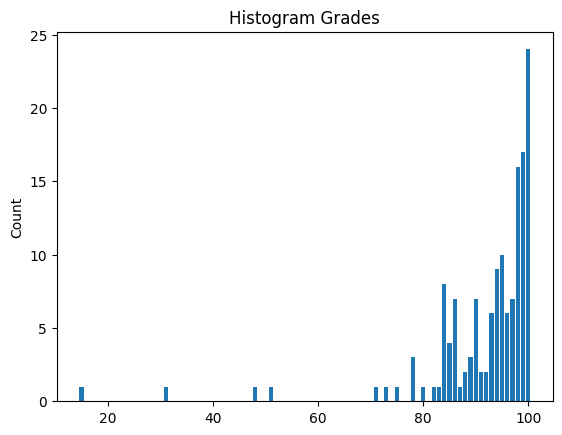

In [27]:
#Grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [28]:
df_word2vec.reset_index(inplace=True, drop=False)
df_word2vec.rename(columns={"index": "code"}, inplace=True)

df_word2vec.head()

,code,#user_prompts,#error,#no,#next,#entropy,#how,#tree,#hyperparameters,#python,prompt_avg_chars,unique_avg_chars,sentiment_point,response_avg_chars,response_unique_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,12.0,1.0,3.0,6.0,32.102124,4.742734,0.071980,0.0,0.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,3.0,4.0,4.0,11.0,0.0,5.991149,1.069514,0.000150,0.0,0.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,0.0,3.0,2.0,6.0,8.0,0.0,4.893447,0.660687,0.022242,0.0,0.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,3.0,9.0,3.0,0.0,0.0,2.776954,0.395713,0.000329,0.0,0.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,26.0,20.0,19.0,14.0,0.0,1.569729,0.271510,0.001997,0.0,0.0


In [29]:
df_word2vec = pd.merge(df_word2vec, question_mapping_scores_word2vec, on="code", how="left")
df_word2vec.head()

,code,#user_prompts,#error,#no,#next,#entropy,#how,#tree,#hyperparameters,#python,...,response_avg_chars,response_unique_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,12.0,1.0,3.0,6.0,...,0.0,0.0,4.787927,14.149032,4.415668,9.602894,18.632718,13.627940,18.385725,8.429681
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,3.0,4.0,4.0,11.0,0.0,...,0.0,0.0,4.795060,14.332826,4.939475,9.523024,19.993489,14.542988,18.531715,9.827648
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,0.0,3.0,2.0,6.0,8.0,0.0,...,0.0,0.0,4.713994,14.462733,3.942634,9.397936,17.911844,13.731732,19.286720,7.987773
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,3.0,9.0,3.0,0.0,0.0,...,0.0,0.0,4.359381,13.130794,4.289430,8.951719,18.482556,13.141172,18.400509,9.616943
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,26.0,20.0,19.0,14.0,0.0,...,0.0,0.0,4.744510,14.218209,4.787616,9.503773,19.720007,14.554828,19.812732,9.766380


In [30]:


temp_df_word2vec = pd.merge(df_word2vec, scores, on='code', how="left")
temp_df_word2vec.dropna(inplace=True)
temp_df_word2vec.drop_duplicates("code",inplace=True, keep="first")
temp_df_word2vec = pd.merge(temp_df_word2vec, total_code_response_df, on='code', how="left")
temp_df_word2vec.drop_duplicates("code",inplace=True, keep="first")

# Now, both temp_df_tf_idf and temp_df_word2vec should have an additional column 'code_count' which indicates the count of code blocks.



temp_df_word2vec.head()

,code,#user_prompts,#error,#no,#next,#entropy,#how,#tree,#hyperparameters,#python,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,grade,code_responses
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,12.0,1.0,3.0,6.0,...,4.787927,14.149032,4.415668,9.602894,18.632718,13.627940,18.385725,8.429681,48.0,14
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,3.0,4.0,4.0,11.0,0.0,...,4.795060,14.332826,4.939475,9.523024,19.993489,14.542988,18.531715,9.827648,99.0,17
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,0.0,3.0,2.0,6.0,8.0,0.0,...,4.713994,14.462733,3.942634,9.397936,17.911844,13.731732,19.286720,7.987773,90.0,7
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,3.0,9.0,3.0,0.0,0.0,...,4.359381,13.130794,4.289430,8.951719,18.482556,13.141172,18.400509,9.616943,97.0,19
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,26.0,20.0,19.0,14.0,0.0,...,4.744510,14.218209,4.787616,9.503773,19.720007,14.554828,19.812732,9.766380,100.0,82


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

merged_df = pd.merge(responses_df, scores, on='code', how='left')
perfect_scores_responses = merged_df[merged_df['grade'] == 100]['response']
vectorizer2 = TfidfVectorizer()

perfect_scores_tfidf = vectorizer2.fit_transform(perfect_scores_responses)

# Extract all responses
all_responses = []
for code, convos in code2convos.items():
    for convo in convos:
        # Ensure 'convo' is a dictionary and 'response' key exists
        if isinstance(convo, dict) and 'response' in convo:
            all_responses.append(convo['response'])

# Now you have a list of all responses
# Proceed with the TF-IDF vectorization
all_responses_tfidf = vectorizer2.transform(all_responses)

# Calculate the cosine similarities
cosine_similarities = cosine_similarity(all_responses_tfidf, perfect_scores_tfidf)


   Scaled Scores
0      83.066009
1      70.604602
2      67.534245
3      61.823871
4      68.867180


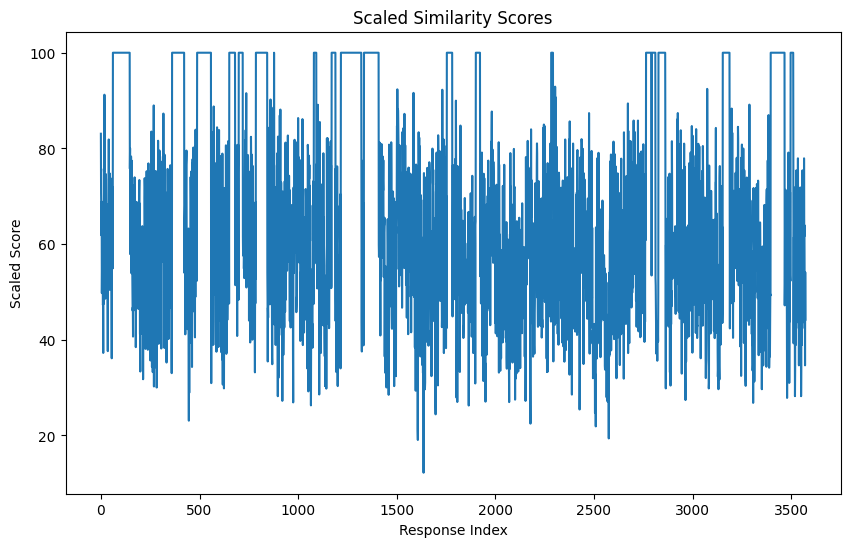

In [32]:
import matplotlib.pyplot as plt

#calculating matrix similarities between students who get 100 and others
max_similarities = cosine_similarities.max(axis=1)
scaled_scores = max_similarities * 100
# Create a DataFrame from the scaled scores
scores_df = pd.DataFrame(scaled_scores, columns=['Scaled Scores'])

# Display the first few rows
print(scores_df.head())

# Plotting the scores
plt.figure(figsize=(10, 6))
plt.plot(scaled_scores)
plt.title('Scaled Similarity Scores')
plt.xlabel('Response Index')
plt.ylabel('Scaled Score')
plt.show()


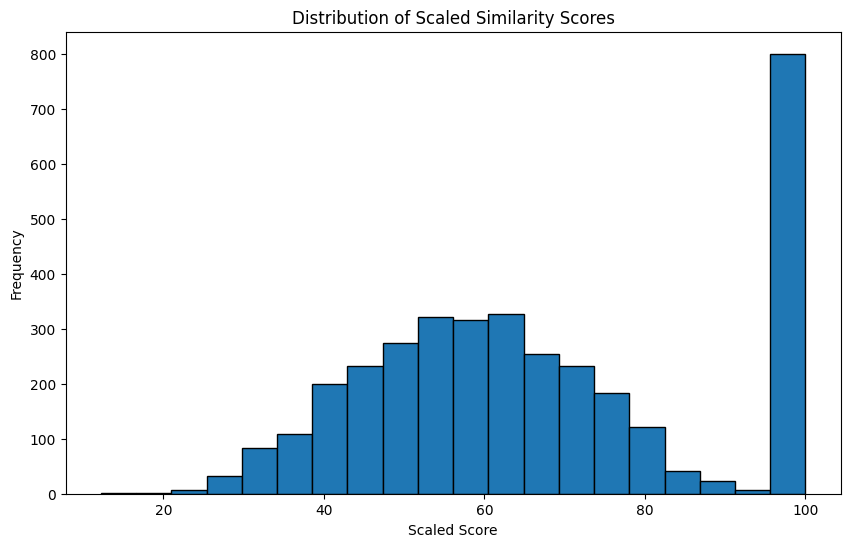

In [33]:
# Plotting a histogram
plt.figure(figsize=(10, 6))
plt.hist(scaled_scores, bins=20, edgecolor='black')
plt.title('Distribution of Scaled Similarity Scores')
plt.xlabel('Scaled Score')
plt.ylabel('Frequency')
plt.show()


In [34]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# DataFrame to store results
similarity_df = pd.DataFrame()

for code in merged_df['code'].unique():
    # Filter the responses for each student
    student_responses = merged_df[merged_df['code'] == code]['response']

    # Calculate TF-IDF vectors for this student's responses
    student_tfidf = vectorizer2.transform(student_responses)

    # Calculate the cosine similarity
    similarities = cosine_similarity(student_tfidf, perfect_scores_tfidf)

    # Compute an average similarity score for this student
    avg_similarity = np.mean(similarities.max(axis=1)) * 100  # Scaling to 0-100

    # Append to the DataFrame
    similarity_df = similarity_df.append({'code': code, 'average_similarity': avg_similarity}, ignore_index=True)

# Display the similarity DataFrame
similarity_df.head()


<ipython-input-34-e7a0b9ce03e0>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similarity_df = similarity_df.append({'code': code, 'average_similarity': avg_similarity}, ignore_index=True)
<ipython-input-34-e7a0b9ce03e0>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similarity_df = similarity_df.append({'code': code, 'average_similarity': avg_similarity}, ignore_index=True)
<ipython-input-34-e7a0b9ce03e0>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similarity_df = similarity_df.append({'code': code, 'average_similarity': avg_similarity}, ignore_index=True)
<ipython-input-34-e7a0b9ce03e0>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conc

,code,average_similarity
0,0031c86e-81f4-4eef-9e0e-28037abf9883,59.539308
1,0225686d-b825-4cac-8691-3a3a5343df2b,68.580414
2,041f950b-c013-409a-a642-cffff60b9d4b,57.114215
3,04f91058-d0f8-4324-83b2-19c671f433dc,62.701598
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,100.000000


In [35]:
temp_df_word2vec = pd.merge(temp_df_word2vec, similarity_df, on='code', how="left")
temp_df_word2vec.drop_duplicates("code",inplace=True, keep="first")

#### Merging scores with features

In [36]:
X_word2vec = temp_df_word2vec[temp_df_word2vec.columns[1:-1]].to_numpy()
y_word2vec = temp_df_word2vec["grade"].to_numpy()

print(X_word2vec.shape, y_word2vec.shape)

(122, 24) (122,)


#### Train/Test split

In [37]:
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X_word2vec, y_word2vec, test_size=0.2, random_state=42)
print("Train set size:", len(X_train_word2vec))
print("Test set size:", len(X_test_word2vec))

Train set size: 97
Test set size: 25


In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

# Initialize and train
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_word2vec, y_train_word2vec)

# Predict and evaluate
lasso_predictions = lasso_model.predict(X_test_word2vec)
lasso_mse = mean_squared_error(y_test_word2vec, lasso_predictions)
print(f"MSE for Lasso Regression: {lasso_mse}")

MSE for Lasso Regression: 6.307775932745488e-05


#Fitting a model

## Predicting and Analyzing

###Word2vec Decision Tree Regressor Model Implementation

In [39]:
#Initial word2vec Decision Tree Regressor Model
model_word2vec_init = DecisionTreeRegressor(criterion='squared_error', random_state=42)
model_word2vec_init.fit(X_train_word2vec, y_train_word2vec)
# word2vec Decision Tree Regressor Model evaluation
y_pred_word2vec_init_test = model_word2vec_init.predict(X_test_word2vec)

#Limit the range between 0-100
for index in range(len(y_pred_word2vec_init_test)):
  if y_pred_word2vec_init_test[index] < 0:
    y_pred_word2vec_init_test[index] = 0
  elif y_pred_word2vec_init_test[index] > 100:
    y_pred_word2vec_init_test[index] = 100

#Test Results
mae_word2vec_init_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init_test)
mse_word2vec_init_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init_test)
rmse_word2vec_init_test = np.sqrt(mse_word2vec_init_test)
r2_word2vec_init_test = r2_score(y_test_word2vec, y_pred_word2vec_init_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init_test}")
print(f"R-squared Test: {r2_word2vec_init_test}")
print(f"Predicted values for testing:{y_pred_word2vec_init_test}")

#Train Results
y_pred_word2vec_init_train = model_word2vec_init.predict(X_train_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_init_train)):
  if y_pred_word2vec_init_train[index] < 0:
    y_pred_word2vec_init_train[index] = 0
  elif y_pred_word2vec_init_train[index] > 100:
    y_pred_word2vec_init_train[index] = 100

mae_word2vec_init_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init_train)
mse_word2vec_init_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init_train)
rmse_word2vec_init_train = np.sqrt(mse_word2vec_init_train)
r2_word2vec_init_train = r2_score(y_train_word2vec, y_pred_word2vec_init_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init_train}")
print(f"R-squared Train: {r2_word2vec_init_train}")
print(f"Predicted values for training:{y_pred_word2vec_init_train}")

Mean Absolute Error (MAE) Test: 1.68
Mean Squared Error (MSE) Test: 44.24
Root Mean Squared Error (RMSE) Test: 6.6513156593263565
R-squared Test: 0.6059344981900066
Predicted values for testing:[ 96.  92.  97.  89. 100.  97. 100.  95.  94.  90.  85.  98.  94.  75.
  98. 100.  85.  97.  90.  15.  85. 100.  99. 100.  94.]
<---------->
Mean Absolute Error (MAE) Train: 0.0
Mean Squared Error (MSE) Train: 0.0
Root Mean Squared Error (RMSE) Train: 0.0
R-squared Train: 1.0
Predicted values for training:[100.  51.  96.  94. 100.  84. 100.  94.  97.  85.  98.  90.  88.  99.
  99.  83.  98.  99.  86. 100. 100.  89.  84.  99. 100. 100.  75.  98.
 100.  97.  95.  95.  80. 100.  95.  99.  99.  93.  98.  90.  82.  89.
  97.  99.  97. 100.  84.  93.  96.  99.  96. 100.  99.  86.  91. 100.
  95.  85. 100. 100.  94.  96.  89.  31.  85.  93.  78.  94.  71.  15.
  93.  73.  94.  84.  98.  98.  99.  99. 100.  90. 100.  92.  90.  95.
 100.  95.  93.  98.  98.  95.  90.  86.  96.  99.  99.  84.  92.]


In [40]:
#Cross validation check for all min_samples_split values
min_samples_split_arr = np.arange(2, 100, 3)

train_error_arr_min_samples_split = []
val_error_arr_min_samples_split = []
for min_samples_split in min_samples_split_arr:

  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save errors for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = DecisionTreeRegressor(
        criterion='squared_error',
        random_state=42,
        min_samples_split=min_samples_split)

    # Fitting the model to be cross validated
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  # After running all splits, we compute the avgof errors in
  # the cross-validation run
  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)


  train_error_arr_min_samples_split.append(train_score_mean)
  val_error_arr_min_samples_split.append(val_score_mean)

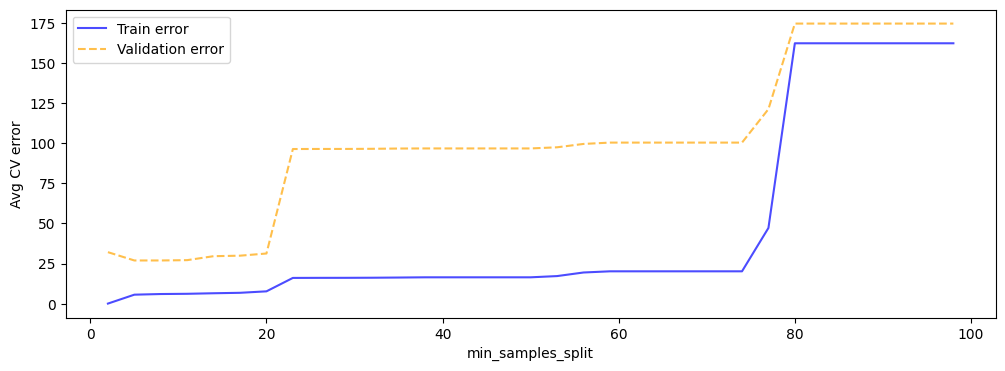

In [41]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_error_arr_min_samples_split, color='blue', alpha=0.7, label='Train error')
ax.plot(min_samples_split_arr, val_error_arr_min_samples_split, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV error')

plt.show()

In [42]:
#Cross Validation for max_depth of the tree
max_depth_arr = np.arange(1, 26)
train_score_error_max_depth = []
val_score_error_max_depth = []
for max_depth in max_depth_arr:
  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save errors for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = DecisionTreeRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  # After running all splits, we compute the avgof errors in
  # the cross-validation run
  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_score_error_max_depth.append(train_score_mean)
  val_score_error_max_depth.append(val_score_mean)

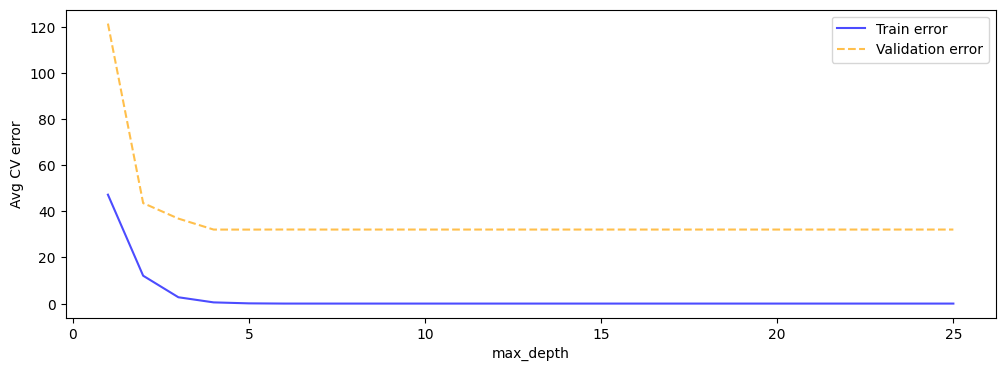

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_error_max_depth, color='blue', alpha=0.7, label='Train error')
ax.plot(max_depth_arr, val_score_error_max_depth, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV error')

plt.show()

In [43]:
#Hyper parameter search space
param_grid = {
    'max_depth': [i for i in range(6,15)],
    'min_samples_split': [j for j in range(60,75)]
}

estimator = DecisionTreeRegressor(criterion='squared_error', random_state=42)
scoring='neg_mean_squared_error'
cv = 5

grid_search_decision_tree_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv
)
grid_search_decision_tree_tune.fit(X_train_word2vec, y_train_word2vec)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'min_samples_split': [60, 61, 62, 63, 64, 65, 66, 67,
                                               68, 69, 70, 71, 72, 73, 74]},
             scoring='neg_mean_squared_error')

In [45]:
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results_decision_tree = pd.DataFrame(grid_search_decision_tree_tune.cv_results_)[cols_to_include]
results_decision_tree.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
0,6,60,-100.46674,162.189136
85,11,70,-100.46674,162.189136
99,12,69,-100.46674,162.189136
98,12,68,-100.46674,162.189136
97,12,67,-100.46674,162.189136
...,...,...,...,...
39,8,69,-100.46674,162.189136
38,8,68,-100.46674,162.189136
37,8,67,-100.46674,162.189136
36,8,66,-100.46674,162.189136


In [46]:
#Use parameters that were the best from previous part
model_word2vec_tuned = DecisionTreeRegressor(
    criterion='squared_error',
    random_state=42,
    max_depth=grid_search_decision_tree_tune.best_params_['max_depth'],
    min_samples_split=grid_search_decision_tree_tune.best_params_['min_samples_split']
)

model_word2vec_tuned.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned_test = model_word2vec_tuned.predict(X_test_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_tuned_test)):
  if y_pred_word2vec_tuned_test[index] < 0:
    y_pred_word2vec_tuned_test[index] = 0
  elif y_pred_word2vec_tuned_test[index] > 100:
    y_pred_word2vec_tuned_test[index] = 100


mae_word2vec_tuned_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned_test)
mse_word2vec_tuned_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned_test)
rmse_word2vec_tuned_test = np.sqrt(mse_word2vec_tuned_test)
r2_word2vec_tuned_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned_test}")
print(f"R-squared Test: {r2_word2vec_tuned_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned_test}")
#Train Results
y_pred_word2vec_tuned_train = model_word2vec_init.predict(X_train_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_tuned_train)):
  if y_pred_word2vec_tuned_train[index] < 0:
    y_pred_word2vec_tuned_train[index] = 0
  elif y_pred_word2vec_tuned_train[index] > 100:
    y_pred_word2vec_tuned_train[index] = 100

mae_word2vec_tuned_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned_train)
mse_word2vec_tuned_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned_train)
rmse_word2vec_tuned_train = np.sqrt(mse_word2vec_tuned_train)
r2_word2vec_tuned_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned_train}")
print(f"R-squared Train: {r2_word2vec_tuned_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned_train}")

Mean Absolute Error (MAE) Test: 2.474730158730159
Mean Squared Error (MSE) Test: 16.2442056941295
Root Mean Squared Error (RMSE) Test: 4.030410114880309
R-squared Test: 0.8553055816373893
Predicted values for testing: [94.2        94.2        99.02380952 84.44444444 99.02380952 99.02380952
 99.02380952 94.2        94.2        84.44444444 84.44444444 99.02380952
 94.2        84.44444444 99.02380952 99.02380952 84.44444444 99.02380952
 84.44444444 32.33333333 84.44444444 99.02380952 99.02380952 99.02380952
 94.2       ]
<---------->
Mean Absolute Error (MAE) Train: 0.0
Mean Squared Error (MSE) Train: 0.0
Root Mean Squared Error (RMSE) Train: 0.0
R-squared Train: 1.0
Predicted values for training: [100.  51.  96.  94. 100.  84. 100.  94.  97.  85.  98.  90.  88.  99.
  99.  83.  98.  99.  86. 100. 100.  89.  84.  99. 100. 100.  75.  98.
 100.  97.  95.  95.  80. 100.  95.  99.  99.  93.  98.  90.  82.  89.
  97.  99.  97. 100.  84.  93.  96.  99.  96. 100.  99.  86.  91. 100.
  95.  85. 1

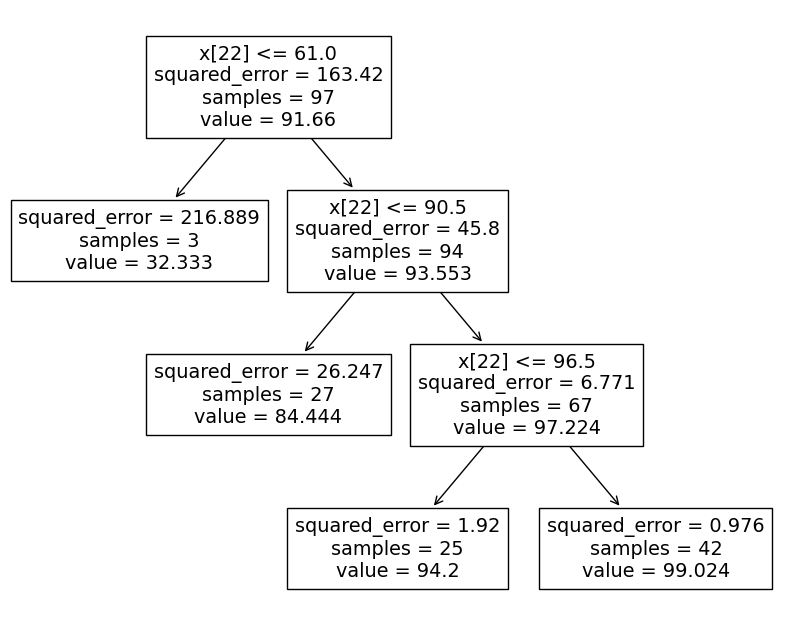

In [47]:
plt.figure(figsize=(10, 8))
plot_tree(model_word2vec_tuned)
plt.show()

###Word2vec Random Forest Regressor Model Implementation

In [48]:
#Random Forest Regressor Model
model_word2vec_init1 = RandomForestRegressor(
  criterion='squared_error',
  random_state=42)

model_word2vec_init1.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_init1_test = model_word2vec_init1.predict(X_test_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_init1_test)):
  if y_pred_word2vec_init1_test[index] < 0:
    y_pred_word2vec_init1_test[index] = 0
  elif y_pred_word2vec_init1_test[index] > 100:
    y_pred_word2vec_init1_test[index] = 100

mae_word2vec_init1_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init1_test)
mse_word2vec_init1_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init1_test)
rmse_word2vec_init1_test = np.sqrt(mse_word2vec_init1_test)
r2_word2vec_init1_test = r2_score(y_test_word2vec, y_pred_word2vec_init1_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init1_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init1_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init1_test}")
print(f"R-squared Test: {r2_word2vec_init1_test}")
print(f"Predicted values for testing: {y_pred_word2vec_init1_test}")

#Train Results
y_pred_word2vec_init1_train = model_word2vec_init1.predict(X_train_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_init1_train)):
  if y_pred_word2vec_init1_train[index] < 0:
    y_pred_word2vec_init1_train[index] = 0
  elif y_pred_word2vec_init1_train[index] > 100:
    y_pred_word2vec_init1_train[index] = 100

mae_word2vec_init1_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init1_train)
mse_word2vec_init1_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init1_train)
rmse_word2vec_init1_train = np.sqrt(mse_word2vec_init1_train)
r2_word2vec_init1_train = r2_score(y_train_word2vec, y_pred_word2vec_init1_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init1_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init1_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init1_train}")
print(f"R-squared Train: {r2_word2vec_init1_train}")
print(f"Predicted values for training: {y_pred_word2vec_init1_train}")

Mean Absolute Error (MAE) Test: 0.5187999999999999
Mean Squared Error (MSE) Test: 1.4686759999999999
Root Mean Squared Error (RMSE) Test: 1.2118894339006343
R-squared Test: 0.986917844825129
Predicted values for testing: [ 95.93  89.75  96.98  88.6  100.    97.01 100.    95.01  93.92  89.78
  85.29  97.94  93.89  76.24  97.96 100.    85.11  96.98  90.1   42.78
  85.25 100.    98.99 100.    93.96]
<---------->
Mean Absolute Error (MAE) Train: 0.33639175257732035
Mean Squared Error (MSE) Train: 2.7552257731958765
Root Mean Squared Error (RMSE) Train: 1.6598872772558613
R-squared Train: 0.9831402520905658
Predicted values for training: [100.    48.52  95.96  93.94 100.    83.92 100.    93.95  97.06  85.01
  97.97  89.64  88.53  99.    99.    82.91  97.97  99.    84.57 100.
 100.    89.06  84.03  98.99 100.   100.    75.62  98.   100.    96.99
  94.97  95.08  79.94 100.    95.06  99.    99.    93.04  97.99  89.97
  82.15  89.14  97.    99.    97.06 100.    84.13  92.94  95.89  99.
  95.95 

In [49]:
#Cross Validation for min_samples_split of the tree
min_samples_split_arr = np.arange(2, 100, 3)

train_error_arr_min_samples_split = []
val_error_arr_min_samples_split = []
for min_samples_split in min_samples_split_arr:

  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save errors for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = RandomForestRegressor(
        criterion='squared_error',
        random_state=42,
        min_samples_split=min_samples_split)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_error_arr_min_samples_split.append(train_score_mean)
  val_error_arr_min_samples_split.append(val_score_mean)

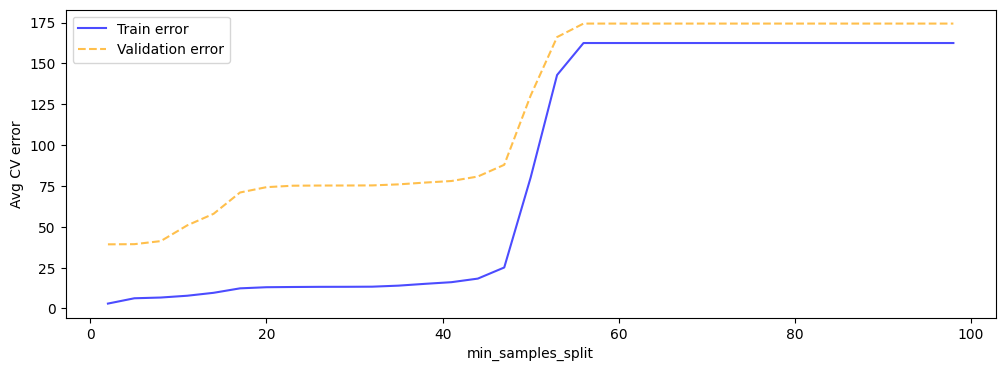

In [50]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_error_arr_min_samples_split, color='blue', alpha=0.7, label='Train error')
ax.plot(min_samples_split_arr, val_error_arr_min_samples_split, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV error')

plt.show()

In [51]:
#Cross Validation for max_depth of the tree
max_depth_arr = np.arange(1, 26)
train_score_error_max_depth = []
val_score_error_max_depth = []
for max_depth in max_depth_arr:
  skf = KFold(n_splits=5)

  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = RandomForestRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing accuracy

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_score_error_max_depth.append(train_score_mean)
  val_score_error_max_depth.append(val_score_mean)

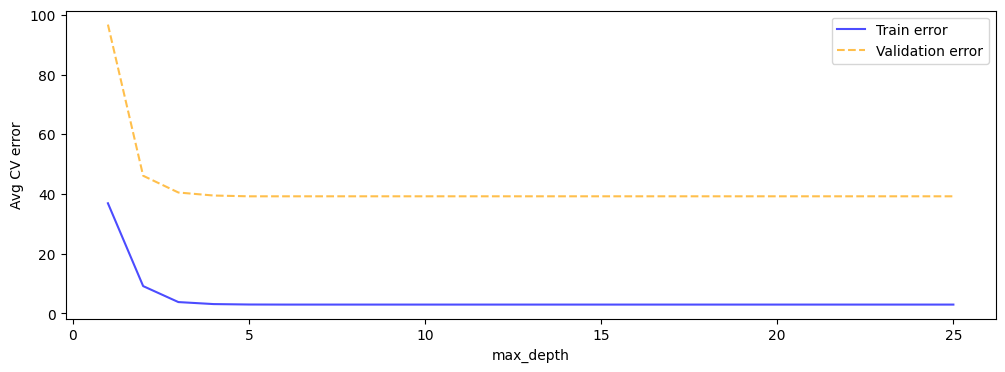

In [52]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_error_max_depth, color='blue', alpha=0.7, label='Train error')
ax.plot(max_depth_arr, val_score_error_max_depth, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV error')

plt.show()

In [53]:
param_grid = {
    'max_depth': [i for i in range(10,18)],
    'min_samples_split': [j for j in range(40,62)],
}

estimator = RandomForestRegressor(criterion='squared_error', random_state=42)
scoring='neg_mean_squared_error'
cv = 5

grid_search_randomforest_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv
)
grid_search_randomforest_tune.fit(X_train_word2vec, y_train_word2vec)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 11, 12, 13, 14, 15, 16, 17],
                         'min_samples_split': [40, 41, 42, 43, 44, 45, 46, 47,
                                               48, 49, 50, 51, 52, 53, 54, 55,
                                               56, 57, 58, 59, 60, 61]},
             scoring='neg_mean_squared_error')

In [54]:
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_randomforest_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
0,10,40,-77.771456,142.757302
22,11,40,-77.771456,142.757302
154,17,40,-77.771456,142.757302
132,16,40,-77.771456,142.757302
110,15,40,-77.771456,142.757302
...,...,...,...,...
40,11,58,-174.368535,220.367622
41,11,59,-174.368535,220.367622
42,11,60,-174.368535,220.367622
43,11,61,-174.368535,220.367622


In [55]:
model_word2vec_tuned1 = RandomForestRegressor(
    criterion='squared_error',
    random_state=42,
    max_depth=grid_search_randomforest_tune.best_params_['max_depth'],
    min_samples_split=grid_search_randomforest_tune.best_params_['min_samples_split'],
    n_estimators = 1000
)
model_word2vec_tuned1.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned1_test = model_word2vec_tuned1.predict(X_test_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_tuned1_test)):
  if y_pred_word2vec_tuned1_test[index] < 0:
    y_pred_word2vec_tuned1_test[index] = 0
  elif y_pred_word2vec_tuned1_test[index] > 100:
    y_pred_word2vec_tuned1_test[index] = 100

mae_word2vec_tuned1_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned1_test)
mse_word2vec_tuned1_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned1_test)
rmse_word2vec_tuned1_test = np.sqrt(mse_word2vec_tuned1_test)
r2_word2vec_tuned1_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned1_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned1_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned1_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned1_test}")
print(f"R-squared Test: {r2_word2vec_tuned1_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned1_test}")
#Train Results
y_pred_word2vec_tuned1_train = model_word2vec_tuned1.predict(X_train_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_tuned1_train)):
  if y_pred_word2vec_tuned1_train[index] < 0:
    y_pred_word2vec_tuned1_train[index] = 0
  elif y_pred_word2vec_tuned1_train[index] > 100:
    y_pred_word2vec_tuned1_train[index] = 100

mae_word2vec_tuned1_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned1_train)
mse_word2vec_tuned1_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned1_train)
rmse_word2vec_tuned1_train = np.sqrt(mse_word2vec_init1_train)
r2_word2vec_tuned1_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned1_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned1_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned1_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned1_train}")
print(f"R-squared Train: {r2_word2vec_tuned1_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned1_train}")


Mean Absolute Error (MAE) Test: 1.4890716574905536
Mean Squared Error (MSE) Test: 3.2984546397683663
Root Mean Squared Error (RMSE) Test: 1.8161648162455868
R-squared Test: 0.9706191866451668
Predicted values for testing: [95.52622275 89.00931386 98.38128921 85.54887717 98.67342617 98.38128921
 98.67342617 94.5691428  94.48673096 87.27555947 83.90767213 98.67342617
 94.48673096 82.79717653 98.67342617 98.67342617 83.90767213 98.38128921
 87.38532749 48.56998236 83.92093545 98.67342617 98.67342617 98.67342617
 94.48673096]
<---------->
Mean Absolute Error (MAE) Train: 1.7522770863485222
Mean Squared Error (MSE) Train: 13.9846575840493
Root Mean Squared Error (RMSE) Train: 1.6598872772558613
R-squared Train: 0.9144252337646575
Predicted values for training: [98.67342617 48.64279717 95.52622275 94.48673096 98.67342617 83.89107963
 98.67342617 94.48673096 98.38128921 83.89107963 98.67342617 87.32974129
 85.54887717 98.67342617 98.67342617 83.87347707 98.67342617 98.67342617
 83.90767213 98

###Word2vec Gradient Boosting Regressor Model Implementation

In [56]:
model_word2vec_init2 = GradientBoostingRegressor(criterion = 'squared_error',learning_rate=0.1, random_state=42)
model_word2vec_init2.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_init2_test = model_word2vec_init2.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_init2_test)):
  if y_pred_word2vec_init2_test[index] < 0:
    y_pred_word2vec_init2_test[index] = 0
  elif y_pred_word2vec_init2_test[index] > 100:
    y_pred_word2vec_init2_test[index] = 100

mae_word2vec_init2_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init2_test)
mse_word2vec_init2_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init2_test)
rmse_word2vec_init2_test = np.sqrt(mse_word2vec_init2_test)
r2_word2vec_init2_test = r2_score(y_test_word2vec, y_pred_word2vec_init2_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init2_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init2_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init2_test}")
print(f"R-squared Test: {r2_word2vec_init2_test}")
print(f"Predicted values for testing: {y_pred_word2vec_init2_test}")

#Train Results
y_pred_word2vec_init2_train = model_word2vec_init2.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_init2_train)):
  if y_pred_word2vec_init2_train[index] < 0:
    y_pred_word2vec_init2_train[index] = 0
  elif y_pred_word2vec_init2_train[index] > 100:
    y_pred_word2vec_init2_train[index] = 100

mae_word2vec_init2_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init2_train)
mse_word2vec_init2_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init2_train)
rmse_word2vec_init2_train = np.sqrt(mse_word2vec_init2_train)
r2_word2vec_init2_train = r2_score(y_train_word2vec, y_pred_word2vec_init2_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init2_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init2_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init2_train}")
print(f"R-squared Train: {r2_word2vec_init2_train}")
print(f"Predicted values for training: {y_pred_word2vec_init2_train}")

Mean Absolute Error (MAE) Test: 1.0038212306426693
Mean Squared Error (MSE) Test: 22.36940752049462
Root Mean Squared Error (RMSE) Test: 4.729630801711125
R-squared Test: 0.8007456645624784
Predicted values for testing: [ 95.99996126  90.96589595  96.99601169  87.94827382 100.
  96.99990651  99.99907446  94.99612024  93.99975284  89.99869269
  86.00158774  97.99985285  93.99824971  77.64544498  97.99985118
  99.99965631  86.00683893  96.99990651  89.99856991  24.3757927
  85.99882117  99.99907446  98.99940961  99.99907446  94.00449741]
<---------->
Mean Absolute Error (MAE) Train: 0.0010500429420691332
Mean Squared Error (MSE) Train: 3.43131527332279e-06
Root Mean Squared Error (RMSE) Train: 0.001852380974131075
R-squared Train: 0.9999999790031325
Predicted values for training: [99.99907446 51.00244503 95.99996126 94.00082062 99.99907446 83.99954107
 99.99907446 93.99919457 96.99990651 84.99944234 97.99985118 89.9986374
 87.9954727  98.99963276 98.99963276 83.00029174 97.99985285 98.99

In [57]:
min_samples_split_arr = np.arange(2, 100, 3)

train_error_arr_min_samples_split = []
val_error_arr_min_samples_split = []
for min_samples_split in min_samples_split_arr:
  skf = KFold(n_splits=5)

  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = GradientBoostingRegressor(
        criterion='squared_error',
        random_state=42,
        min_samples_split=min_samples_split)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)


  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_error_arr_min_samples_split.append(train_score_mean)
  val_error_arr_min_samples_split.append(val_score_mean)

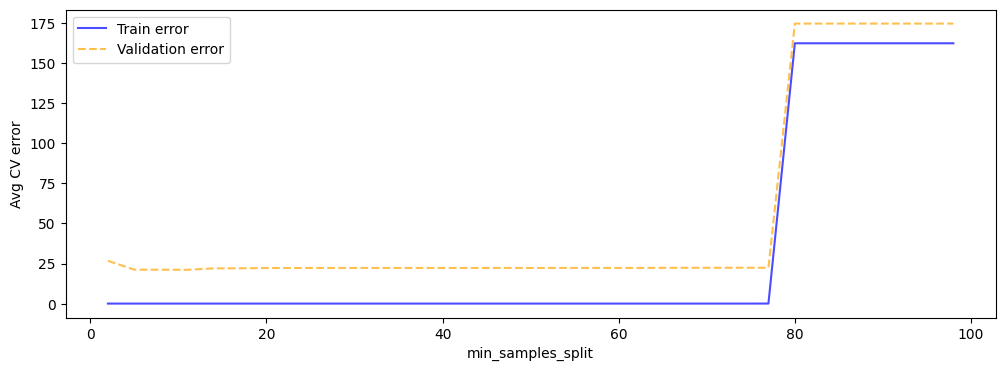

In [58]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_error_arr_min_samples_split, color='blue', alpha=0.7, label='Train error')
ax.plot(min_samples_split_arr, val_error_arr_min_samples_split, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV error')

plt.show()

In [59]:
max_depth_arr = np.arange(1, 26)
train_score_error_max_depth = []
val_score_error_max_depth = []
for max_depth in max_depth_arr:
  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save accuracies for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = GradientBoostingRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing accuracy

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_score_error_max_depth.append(train_score_mean)
  val_score_error_max_depth.append(val_score_mean)

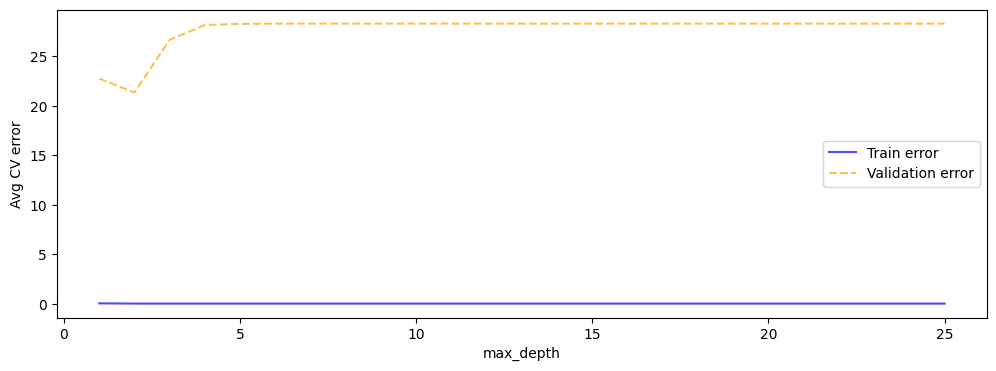

In [60]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_error_max_depth, color='blue', alpha=0.7, label='Train error')
ax.plot(max_depth_arr, val_score_error_max_depth, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV error')

plt.show()

In [61]:
param_grid = {
    'max_depth': [i for i in range(3,16)],
    'min_samples_split': [j for j in range(60,81)]
}

estimator = GradientBoostingRegressor(criterion='squared_error', random_state=42)
scoring='neg_mean_squared_error'
cv = 5

grid_search_gradient_boosting_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv
)
grid_search_gradient_boosting_tune.fit(X_train_word2vec, y_train_word2vec)

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(criterion='squared_error',
                                                 random_state=42),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15],
                         'min_samples_split': [60, 61, 62, 63, 64, 65, 66, 67,
                                               68, 69, 70, 71, 72, 73, 74, 75,
                                               76, 77, 78, 79, 80]},
             scoring='neg_mean_squared_error')

In [62]:
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_gradient_boosting_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
65,6,62,-22.253400,35.065303
86,7,62,-22.253407,35.065299
254,15,62,-22.253464,35.065262
212,13,62,-22.253464,35.065262
170,11,62,-22.253464,35.065262
...,...,...,...,...
83,6,80,-174.744524,221.101220
82,6,79,-174.744524,221.101220
188,11,80,-174.744524,221.101220
250,14,79,-174.744524,221.101220


In [63]:
model_word2vec_tuned2 = GradientBoostingRegressor(
    criterion='squared_error',
    random_state=42,
    max_depth=grid_search_gradient_boosting_tune.best_params_['max_depth'],
    min_samples_split=grid_search_gradient_boosting_tune.best_params_['min_samples_split'],
    n_estimators = 1000
)
model_word2vec_tuned2.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned2_test = model_word2vec_tuned2.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_tuned2_test)):
  if y_pred_word2vec_tuned2_test[index] < 0:
    y_pred_word2vec_tuned2_test[index] = 0
  elif y_pred_word2vec_tuned2_test[index] > 100:
    y_pred_word2vec_tuned2_test[index] = 100

mae_word2vec_tuned2_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned2_test)
mse_word2vec_tuned2_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned2_test)
rmse_word2vec_tuned2_test = np.sqrt(mse_word2vec_tuned2_test)
r2_word2vec_tuned2_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned2_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned2_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned2_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned2_test}")
print(f"R-squared Test: {r2_word2vec_tuned2_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned2_test}")
#Train Results
y_pred_word2vec_tuned2_train = model_word2vec_tuned2.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_tuned2_train)):
  if y_pred_word2vec_tuned2_train[index] < 0:
    y_pred_word2vec_tuned2_train[index] = 0
  elif y_pred_word2vec_tuned2_train[index] > 100:
    y_pred_word2vec_tuned2_train[index] = 100

mae_word2vec_tuned2_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned2_train)
mse_word2vec_tuned2_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned2_train)
rmse_word2vec_tuned2_train = np.sqrt(mse_word2vec_tuned2_train)
r2_word2vec_tuned2_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned2_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned2_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned2_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned2_train}")
print(f"R-squared Train: {r2_word2vec_tuned2_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned2_train}")

Mean Absolute Error (MAE) Test: 0.16280685973764605
Mean Squared Error (MSE) Test: 0.398530233888562
Root Mean Squared Error (RMSE) Test: 0.6312925105595361
R-squared Test: 0.9964501126445807
Predicted values for testing: [ 95.99859014  91.00261013  97.00034083  87.97370198  99.99626941
  97.00185097  99.99971256  95.006671    93.99344996  89.99871581
  85.99953085  97.99973927  93.99325936  78.00318508  98.00007423
  99.99903881  86.00257148  97.00058315  89.99705821  50.99552982
  86.00545273  99.99889672  98.99532011 100.          93.99450928]
<---------->
Mean Absolute Error (MAE) Train: 1.2895026813269984e-05
Mean Squared Error (MSE) Train: 3.5941383972502433e-10
Root Mean Squared Error (RMSE) Train: 1.8958212988702925e-05
R-squared Train: 0.9999999999978006
Predicted values for training: [ 99.99996809  50.99999747  95.99999538  93.99998049 100.
  84.00002655 100.          93.99991513  96.9999851   84.99998637
  98.00002283  89.99999655  87.9999816   98.99999147  99.00000624
  83.

###Word2vec XGBoost Regressor Model Implementation

In [64]:
model_word2vec_init3 = xgb.XGBRegressor()
model_word2vec_init3.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_init3_test = model_word2vec_init3.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_init3_test)):
  if y_pred_word2vec_init3_test[index] < 0:
    y_pred_word2vec_init3_test[index] = 0
  elif y_pred_word2vec_init3_test[index] > 100:
    y_pred_word2vec_init3_test[index] = 100


mae_word2vec_init3_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init3_test)
mse_word2vec_init3_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init3_test)
rmse_word2vec_init3_test = np.sqrt(mse_word2vec_init3_test)
r2_word2vec_init3_test = r2_score(y_test_word2vec, y_pred_word2vec_init3_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init3_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init3_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init3_test}")
print(f"R-squared Test: {r2_word2vec_init3_test}")
print(f"Predicted values for testing: {y_pred_word2vec_init3_test}")
#Train Results
y_pred_word2vec_init3_train = model_word2vec_init3.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_init3_train)):
  if y_pred_word2vec_init3_train[index] < 0:
    y_pred_word2vec_init3_train[index] = 0
  elif y_pred_word2vec_init3_train[index] > 100:
    y_pred_word2vec_init3_train[index] = 100


mae_word2vec_init3_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init3_train)
mse_word2vec_init3_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init3_train)
rmse_word2vec_init3_train = np.sqrt(mse_word2vec_init3_train)
r2_word2vec_init3_train = r2_score(y_train_word2vec, y_pred_word2vec_init3_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init3_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init3_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init3_train}")
print(f"R-squared Train: {r2_word2vec_init3_train}")
print(f"Predicted values for training: {y_pred_word2vec_init3_train}")

Mean Absolute Error (MAE) Test: 0.3687809753417969
Mean Squared Error (MSE) Test: 1.3424726694106357
Root Mean Squared Error (RMSE) Test: 1.158651228545776
R-squared Test: 0.9880419944363132
Predicted values for testing: [ 95.9933    90.03237   97.02888   88.06354   99.99885   97.032295
  99.99877   95.00472   93.99692   90.0007    85.99326   98.00061
  93.99462   78.5459    98.000145  99.99885   85.98132   97.03137
  90.97046   42.491375  85.98346  100.        99.00139  100.
  93.99738 ]
<---------->
Mean Absolute Error (MAE) Train: 0.000424070456593307
Mean Squared Error (MSE) Train: 3.6789564190482836e-07
Root Mean Squared Error (RMSE) Train: 0.0006065440148124688
R-squared Train: 0.9999999977487769
Predicted values for training: [ 99.999626  50.9998    95.99997   93.998314  99.99975   84.00037
  99.99992   93.99962   97.00216   85.00042   98.0017    90.000755
  88.00022   98.99972   99.0002    82.99952   98.000084  98.99993
  85.99984   99.99944   99.99963   88.99941   84.00066   9

In [65]:
param_grid = {
    'max_depth': [3,6,10],
    'n_estimators': [100,150,200,250,300,500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
    'colsample_bytree': [0.3, 0.55, 0.7]
}

estimator = xgb.XGBRegressor()
scoring='neg_mean_squared_error'
cv = 5

grid_search_XGBoost_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    verbose=1
)
grid_search_XGBoost_tune.fit(X_train_word2vec, y_train_word2vec)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.55, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 150, 200, 250, 300, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [66]:
cols_to_include = ['param_max_depth', 'param_n_estimators','param_learning_rate','param_colsample_bytree','mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_XGBoost_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_n_estimators,param_learning_rate,param_colsample_bytree,mean_test_score,std_test_score
323,10,500,1,0.7,-29.657584,53.750704
322,10,300,1,0.7,-29.657584,53.750704
321,10,250,1,0.7,-29.657584,53.750704
320,10,200,1,0.7,-29.657584,53.750704
319,10,150,1,0.7,-29.657584,53.750704
...,...,...,...,...,...,...
101,6,500,1,0.3,-247.771879,140.958090
99,6,250,1,0.3,-247.771879,140.958090
98,6,200,1,0.3,-247.771879,140.958090
96,6,100,1,0.3,-247.771879,140.958090


In [67]:
model_word2vec_tuned3 = xgb.XGBRegressor(
    max_depth = grid_search_XGBoost_tune.best_params_['max_depth'],
    n_estimators = grid_search_XGBoost_tune.best_params_['n_estimators'],
    learning_rate = grid_search_XGBoost_tune.best_params_['learning_rate'],
    colsample_bytree = grid_search_XGBoost_tune.best_params_['colsample_bytree']
)
model_word2vec_tuned3.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned3_test = model_word2vec_tuned3.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_tuned3_test)):
  if y_pred_word2vec_tuned3_test[index] < 0:
    y_pred_word2vec_tuned3_test[index] = 0
  elif y_pred_word2vec_tuned3_test[index] > 100:
    y_pred_word2vec_tuned3_test[index] = 100

mae_word2vec_tuned3_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned3_test)
mse_word2vec_tuned3_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned3_test)
rmse_word2vec_tuned3_test = np.sqrt(mse_word2vec_tuned3_test)
r2_word2vec_tuned3_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned3_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned3_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned3_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned3_test}")
print(f"R-squared Test: {r2_word2vec_tuned3_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned3_test}")
#Train Results
y_pred_word2vec_tuned3_train = model_word2vec_tuned3.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_tuned3_train)):
  if y_pred_word2vec_tuned3_train[index] < 0:
    y_pred_word2vec_tuned3_train[index] = 0
  elif y_pred_word2vec_tuned3_train[index] > 100:
    y_pred_word2vec_tuned3_train[index] = 100


mae_word2vec_tuned3_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned3_train)
mse_word2vec_tuned3_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned3_train)
rmse_word2vec_tuned3_train = np.sqrt(mse_word2vec_tuned3_train)
r2_word2vec_tuned3_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned3_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned3_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned3_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned3_train}")
print(f"R-squared Train: {r2_word2vec_tuned3_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned3_train}")

Mean Absolute Error (MAE) Test: 1.5312335205078125
Mean Squared Error (MSE) Test: 12.506827267864718
Root Mean Squared Error (RMSE) Test: 3.536499295612077
R-squared Test: 0.8885960858191225
Predicted values for testing: [95.98793  89.834915 97.27002  90.19016  99.99213  97.4031   99.99232
 95.03492  93.96158  88.786705 83.80124  98.12092  93.30466  85.64316
 97.967705 99.954704 84.214745 97.072296 91.87543  32.94101  84.32319
 99.92463  99.0256   99.99812  93.36919 ]
<---------->
Mean Absolute Error (MAE) Train: 0.00024626427090045105
Mean Squared Error (MSE) Train: 1.1617559027502832e-07
Root Mean Squared Error (RMSE) Train: 0.00034084540524265296
R-squared Train: 0.9999999992890996
Predicted values for training: [100.        50.999046  96.00023   94.000534 100.        84.00005
  99.999344  93.99967   97.00013   84.99933   97.99994   89.99995
  88.00006   98.999695  98.99998   83.00033   97.99984   99.00068
  85.99921  100.       100.        89.00034   83.99982   99.00029
 100.      

###Word2vec CatBoost Regression Implementation

In [68]:
model_word2vec_init4 = CatBoostRegressor(verbose=0)
model_word2vec_init4.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_init4_test = model_word2vec_init4.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_init4_test)):
  if y_pred_word2vec_init4_test[index] < 0:
    y_pred_word2vec_init4_test[index] = 0
  elif y_pred_word2vec_init4_test[index] > 100:
    y_pred_word2vec_init4_test[index] = 100

mae_word2vec_init4_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init4_test)
mse_word2vec_init4_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init4_test)
rmse_word2vec_init4_test = np.sqrt(mse_word2vec_init4_test)
r2_word2vec_init4_test = r2_score(y_test_word2vec, y_pred_word2vec_init4_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init4_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init4_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init4_test}")
print(f"R-squared Test: {r2_word2vec_init4_test}")
print(f"Predicted values for testing: {y_pred_word2vec_init4_test}")

#Train Results
y_pred_word2vec_init4_train = model_word2vec_init4.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_init4_train)):
  if y_pred_word2vec_init4_train[index] < 0:
    y_pred_word2vec_init4_train[index] = 0
  elif y_pred_word2vec_init4_train[index] > 100:
    y_pred_word2vec_init4_train[index] = 100

mae_word2vec_init4_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init4_train)
mse_word2vec_init4_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init4_train)
rmse_word2vec_init4_train = np.sqrt(mse_word2vec_init4_train)
r2_word2vec_init4_train = r2_score(y_train_word2vec, y_pred_word2vec_init4_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init4_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init4_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init4_train}")
print(f"R-squared Train: {r2_word2vec_init4_train}")
print(f"Predicted values for training: {y_pred_word2vec_init4_train}")

Mean Absolute Error (MAE) Test: 1.5570187405586873
Mean Squared Error (MSE) Test: 7.406277468017183
Root Mean Squared Error (RMSE) Test: 2.721447678721232
R-squared Test: 0.9340289681966945
Predicted values for testing: [95.87396456 91.55669082 95.47822908 89.58068423 97.18908089 96.33986099
 99.53396039 94.22238089 94.73365457 91.12096464 88.47169984 97.0170831
 94.24528684 86.52823282 98.18300549 98.06762202 87.24457913 97.03805957
 90.8097472  56.98140283 86.90907112 98.8942938  98.24513144 99.26822456
 93.52963662]
<---------->
Mean Absolute Error (MAE) Train: 0.018915806515374417
Mean Squared Error (MSE) Train: 0.0006181227232268983
Root Mean Squared Error (RMSE) Train: 0.024862073992869105
R-squared Train: 0.9999962175900821
Predicted values for training: [ 99.99750624  51.00109566  95.99105717  93.96427542  99.9966629
  84.03386642  99.97698727  94.085332    96.98120921  85.00537293
  98.04606999  89.96011884  87.96899948  98.9540894   99.02987833
  83.02336173  98.00536646  98.

In [69]:
param_grid = {
  'depth': [x for x in range(0,10)],
  'learning_rate': [0.01, 0.05, 1]
}

estimator = CatBoostRegressor(verbose=0)
scoring='neg_mean_squared_error'
cv = 5

grid_search_CatBoost_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    verbose=1
)
grid_search_CatBoost_tune.fit(X_train_word2vec, y_train_word2vec)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x793e6710b310>,
             param_grid={'depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'learning_rate': [0.01, 0.05, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [70]:
cols_to_include = ['param_depth','param_learning_rate','mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_CatBoost_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_depth,param_learning_rate,mean_test_score,std_test_score
4,1,0.05,-21.229631,36.368754
5,1,1,-27.641713,44.352398
3,1,0.01,-27.651809,49.224423
7,2,0.05,-29.946863,56.973736
6,2,0.01,-34.090607,64.783994
8,2,1,-34.738295,58.320090
11,3,1,-35.801076,60.633402
10,3,0.05,-37.812625,74.406947
9,3,0.01,-44.596435,87.015751
13,4,0.05,-52.438853,102.937649


In [71]:
model_word2vec_tuned4 = CatBoostRegressor(
    depth = grid_search_CatBoost_tune.best_params_['depth'],
    learning_rate = grid_search_CatBoost_tune.best_params_['learning_rate'],
    verbose= 0
)

model_word2vec_tuned4.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned4_test = model_word2vec_tuned4.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_tuned4_test)):
  if y_pred_word2vec_tuned4_test[index] < 0:
    y_pred_word2vec_tuned4_test[index] = 0
  elif y_pred_word2vec_tuned4_test[index] > 100:
    y_pred_word2vec_tuned4_test[index] = 100

mae_word2vec_tuned4_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned4_test)
mse_word2vec_tuned4_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned4_test)
rmse_word2vec_tuned4_test = np.sqrt(mse_word2vec_tuned4_test)
r2_word2vec_tuned4_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned4_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned4_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned4_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned4_test}")
print(f"R-squared Test: {r2_word2vec_tuned4_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned4_test}")

#Train Results
y_pred_word2vec_tuned4_train = model_word2vec_tuned4.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_tuned4_train)):
  if y_pred_word2vec_tuned4_train[index] < 0:
    y_pred_word2vec_tuned4_train[index] = 0
  elif y_pred_word2vec_tuned4_train[index] > 100:
    y_pred_word2vec_tuned4_train[index] = 100

mae_word2vec_tuned4_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned4_train)
mse_word2vec_tuned4_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned4_train)
rmse_word2vec_tuned4_train = np.sqrt(mse_word2vec_tuned4_train)
r2_word2vec_tuned4_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned4_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned4_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned4_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned4_train}")
print(f"R-squared Train: {r2_word2vec_tuned4_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned4_train}")

Mean Absolute Error (MAE) Test: 0.4280044901341276
Mean Squared Error (MSE) Test: 0.7086632238293621
Root Mean Squared Error (RMSE) Test: 0.8418213728751262
R-squared Test: 0.9936876191475451
Predicted values for testing: [95.76019969 91.69608032 97.22833981 88.45673632 99.82246573 97.16349956
 99.87134604 95.45320212 94.0120804  89.95709215 85.96436845 97.51708656
 94.01642739 76.56043057 97.96159026 99.66170848 85.98098365 97.06732341
 90.04919156 51.48586088 85.64454553 99.88796124 99.15027425 99.8981372
 94.40901177]
<---------->
Mean Absolute Error (MAE) Train: 0.17955088063877897
Mean Squared Error (MSE) Train: 0.08584463196486197
Root Mean Squared Error (RMSE) Train: 0.2929925459203049
R-squared Train: 0.9994747004516341
Predicted values for training: [ 99.87134604  51.16415233  95.86011257  93.67998927  99.88361425
  84.4907958   99.77726214  94.01642739  97.15915257  85.10815356
  97.96593725  90.01047013  87.88218625  99.27340823  98.93419844
  83.26893236  97.96593725  98.93